In [1]:
import torch
import torch.nn as nn
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as utils

In [2]:
DATA_DIR_DEEPTHOUGHT="/storage/yw18581/data"
data_dir = DATA_DIR_DEEPTHOUGHT
train_test = os.path.join(data_dir, "train_validation_test")

In [3]:
data = np.load("/storage/yw18581/data/train_validation_test/Xy_train+val_clean_300_24_10_25.npz")
x = data["x"]
y = data['y']


In [35]:

tensor_x = torch.from_numpy(x) # transform to torch tensors
tensor_y = torch.from_numpy(y)

xy_dataset = utils.TensorDataset(tensor_x,tensor_y)

In [20]:
class UNetDataset(Dataset):
    def __init__(self, xy_dataset, transform=None):
        self.transform = transform
        self._data = xy_dataset

    def __getitem__(self, idx):
        image = self._data[idx][0]
        mask = self._data[idx][1]
        sample = {'image': image, 'masks': mask}

        if self.transform:
            sample = self.transform(sample)
        return sample

    def __len__(self):
        return len(self._data)


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, mask = sample['image'], sample['masks']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose(2,0)
        mask = mask.transpose(2,0)
        return {'image': image,
                'masks': mask}



In [21]:
train_dataset = UNetDataset(xy_dataset, transform=ToTensor())

In [22]:
dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4)

In [23]:
for i, data in enumerate(dataloader):
    print(data['image'].size(), data['image'].dtype)
    if i==4:
        break

torch.Size([2, 1, 1400, 1400]) torch.uint8
torch.Size([2, 1, 1400, 1400]) torch.uint8
torch.Size([2, 1, 1400, 1400]) torch.uint8
torch.Size([2, 1, 1400, 1400]) torch.uint8
torch.Size([2, 1, 1400, 1400]) torch.uint8


In [24]:
IMG_WIDTH = 1400
IMG_HEIGHT = 1400


def double_conv(in_channels, out_channels):
    conv_block = nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, padding=1),
                               nn.ReLU(inplace=True),
                               nn.Conv2d(out_channels, out_channels, 3, padding=1),
                               nn.ReLU(inplace=True))
    return conv_block


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()

        self.conv_block_down1 = double_conv(1, 64)
        self.conv_block_down2 = double_conv(64, 128)
        self.conv_block_down3 = double_conv(128, 256)
        self.conv_block_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_block_up3 = double_conv(256 + 512, 256)
        self.conv_block_up2 = double_conv(128 + 256, 128)
        self.conv_block_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, n_class, 1)


    def forward(self, x):
        convb1 = self.conv_block_down1(x)
        x = self.maxpool(convb1)

        convb2 = self.conv_block_down2(x)
        x = self.maxpool(convb2)

        convb3 = self.conv_block_down3(x)
        x = self.maxpool(convb3)

        x = self.conv_block_down4(x)
        x = self.upsample(x)
        x = torch.cat([x, convb3], dim=1)

        x = self.conv_block_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, convb2], dim=1)

        x = self.conv_block_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, convb1], dim=1)

        x = self.conv_block_up1(x)

        out = self.conv_last(x)

        return out
  

In [25]:
def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    return loss.mean()

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [27]:
net = UNet(n_class=2)

In [28]:
net.to(device)

UNet(
  (conv_block_down1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (maxpo

In [43]:
import torch.optim as optim

In [44]:
optimizer = optim.Adam(net.parameters(),lr=1e-5)

In [45]:
criterion = dice_loss

In [46]:
for epoch in range(5):  #loop over the dataset multiple times
    print("Epoch {}\n".format(epoch))
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs=data['image'].half().to(device)
        labels = data['masks'].half().to(device)
        #print(inputs.size(), labels.size())
        # zero the parameter gradients
        optimizer.zero_grad()
        
        #forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 2000 mini_batches
            print('[%d, %5d] loss: %.3f' % 
                 (epoch + 1, i + 1, running_loss / 20))

print('Finished Training')

Epoch 0



RuntimeError: Input type (torch.cuda.HalfTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [41]:
running_loss

0.0

In [20]:
import matplotlib.pyplot as plt

RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

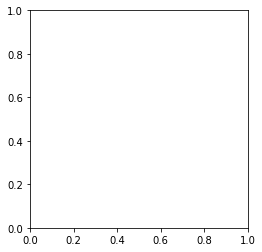

In [22]:
plt.imshow(outputs.cpu())[0]